# Classification model

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy

from sklearn import metrics
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

import pkg_resources
# list packages to be checked
root_packages = ['pandas', 'matplotlib', 'seaborn', 'numpy', 'scikit-learn']

# print versions, but check if package is imported first
for m in pkg_resources.working_set:
    if m.project_name.lower() in root_packages:
        print(f"{m.project_name}=={m.version}")

seaborn==0.10.1
scikit-learn==0.23.1
pandas==1.0.5
numpy==1.19.5
matplotlib==3.2.2


In [2]:
SEED = 1

## Data Preparation

In [16]:
df = pd.read_csv("../data/heart.csv") # download heart dataset
attr = df[df.columns[1:13]]
target = df[df.columns[13]]

X_train, X_test, y_train, y_test = train_test_split(attr, 
                                                    target, 
                                                    test_size=0.33, 
                                                    random_state=SEED)
df

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,57,0,0,140,241,0,1,123,1,0.2,1,0,3,0
299,45,1,3,110,264,0,1,132,0,1.2,1,0,3,0
300,68,1,0,144,193,1,1,141,0,3.4,1,2,3,0
301,57,1,0,130,131,0,1,115,1,1.2,1,1,3,0


## Helper functions

In [39]:
def get_preds(model, X_test):
    return model.predict(X_test)

def get_metric_scores(y_test, preds):
    acc = metrics.accuracy_score(y_test, preds)
    prec = metrics.precision_score(y_test, preds) 
    rec = metrics.recall_score(y_test, preds)
    return [acc, prec, rec]

def get_roc(y_test, preds):
    fpr, tpr, thresh = metrics.roc_curve(y_test, preds)
    auc = metrics.roc_auc_score(y_test, preds)
    plt.plot(fpr,tpr,label="data 1, auc="+str(auc))

In [ ]:
plt.figure(0).clf()

pred = np.random.rand(1000)
label = np.random.randint(2, size=1000)
fpr, tpr, thresh = metrics.roc_curve(label, pred)
auc = metrics.roc_auc_score(label, pred)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))

pred = np.random.rand(1000)
label = np.random.randint(2, size=1000)
fpr, tpr, thresh = metrics.roc_curve(label, pred)
auc = metrics.roc_auc_score(label, pred)
plt.plot(fpr,tpr,label="data 2, auc="+str(auc))

plt.legend(loc=0)


In [25]:
def get_models(X_train, y_train, random_state=SEED):
    lrm = LogisticRegression(random_state=SEED).fit(X_train, y_train)
    rfm = RandomForestClassifier(random_state=SEED).fit(X_train, y_train)
    nnm = MLPClassifier(random_state=SEED).fit(X_train, y_train)
    return lrm, rfm, nnm

def get_comparison_grid(models, X_test, y_test, _type):
    preds = []
    scores = []

    for i in models:
        preds.append(get_preds(i, X_test))

    for i in preds:
        scores.append(get_metric_scores(y_test, i))
        
    scores = pd.DataFrame(scores)
    scores.columns =['Accuracy', 'Precision', 'Recall']
    scores.index = [_type+' Logistic Regression', _type+' Random Forest', _type+' Neural Network']
    return scores

def create_matrix(y_test, preds, model):
    cm = metrics.confusion_matrix(y_test, preds)
    cm = pd.DataFrame(cm, index=['Diseased', 'Not-diseased'], columns=['Diseased', 'Not-diseased'])
    sns.heatmap(cm, annot=True, annot_kws={"size": 16})
    plt.title(f'Confusion Matrix: {model}');

## Evaluation - benchmark

In [31]:
models = get_models(X_train, y_train, random_state=SEED)

preds_test = []
preds_train = []
for i in models:
    preds_test.append(get_preds(i, X_test))
    preds_train.append(get_preds(i, X_train))
    
a = get_comparison_grid(models, X_test, y_test, 'Test - ')
b = get_comparison_grid(models, X_train, y_train, 'Train - ')
pd.concat([a,b])

/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,Accuracy,Precision,Recall
Test - Logistic Regression,0.790000,0.779661,0.851852
Test - Random Forest,0.760000,0.777778,0.777778
Test - Neural Network,0.570000,0.677419,0.388889
Train - Logistic Regression,0.881773,0.865546,0.927928
Train - Random Forest,1.000000,1.000000,1.000000
Train - Neural Network,0.679803,0.773810,0.585586


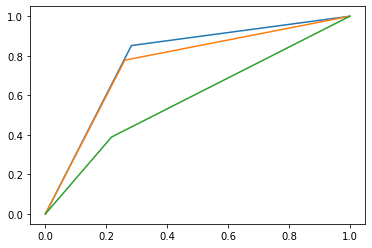

In [40]:
for i in preds:
    get_roc(y_test, i)
    #get_roc(y_train, y_train)

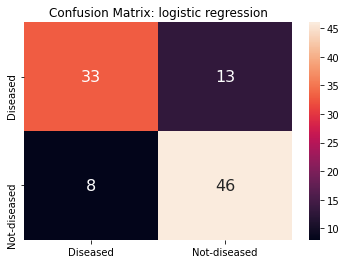

In [15]:
create_matrix(y_test, preds[0], 'logistic regression')

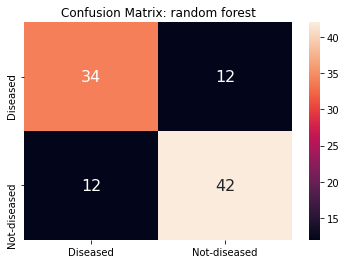

In [12]:
create_matrix(y_test, preds[1], 'random forest')

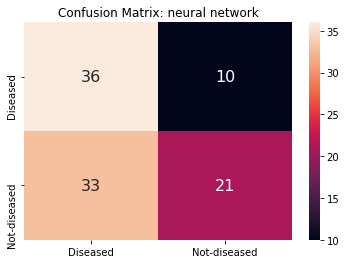

In [13]:
create_matrix(y_test, preds[2], 'neural network')